# A Financial Fraud Predictive AI Model.

## Import dependencies

In [236]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import statsmodels.api as sm
import joblib
from scipy.stats import uniform, anderson
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import OneClassSVM, SVC
from sklearn.datasets import make_blobs
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, make_scorer, f1_score

## Read Fraud Dataset

In [238]:
df_original = pd.read_csv("/Users/luisorellanaaltamirano/Documents/Machine_Learning/Synthetic_Financial_datasets_log.csv")

print(df_original.columns)

#Unify fraud flags.
df_original['isFraud'] = df_original['isFraud'] | df_original['isFlaggedFraud']
df_original.drop(['isFlaggedFraud'], inplace=True, axis=1)

df = df_original.copy()

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')


## Data Analysis

### What is the proportion of fraudulent transactions vs non fraudulent?

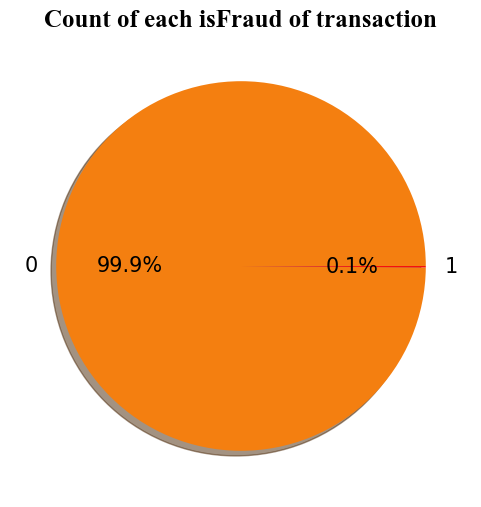

In [19]:
counts = df_original['isFraud'].value_counts()
plt.figure(figsize = (6,6))
plt.pie(counts, labels = counts.index, autopct = "%1.1f%%", colors=['#F47F10', '#F41010', '#F47810', '#F4C010','#F4D510'], shadow = True,explode = (0, 0),textprops={'fontsize': 15})
plt.title('Count of each isFraud of transaction', fontweight = 'bold', fontsize = 18, fontfamily = 'times new roman')
plt.show()

### Transform categorical variables into numerics

In [31]:
#convert categorical data to integers
le = LabelEncoder()
df['nameOrig'] = le.fit_transform(df['nameOrig'])
df['nameDest'] = le.fit_transform(df['nameDest'])
df['type'] = le.fit_transform(df['type']) # 0(0.0)=CASH_IN; 1(0.25)=CASH_OUT; 2(0.5)=DEBIT; 3(0.75)=PAYMENT; 4(1.0)=TRANSFER

 ### What is the proportion of amount for every type

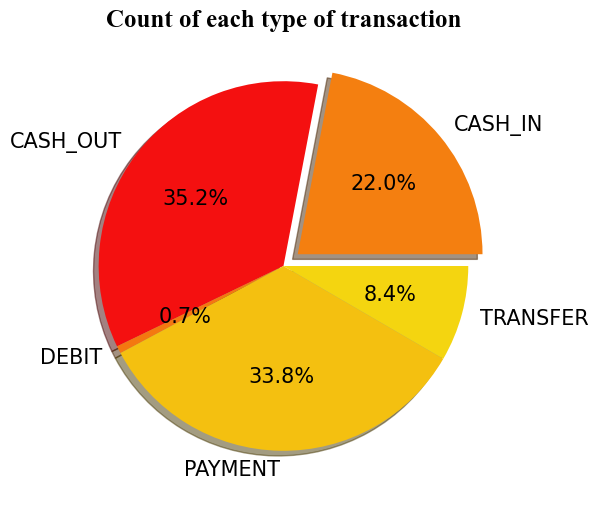

In [34]:
counts = df_original.groupby('type').count()['amount']
plt.figure(figsize = (6,6))
plt.pie(counts, labels = counts.index, autopct = "%1.1f%%", colors=['#F47F10', '#F41010', '#F47810', '#F4C010','#F4D510'], shadow = True,explode = (0.1, 0, 0, 0, 0),textprops={'fontsize': 15})
plt.title('Count of each type of transaction', fontweight = 'bold', fontsize = 18, fontfamily = 'times new roman')
plt.show()

### What types are mostly fraud

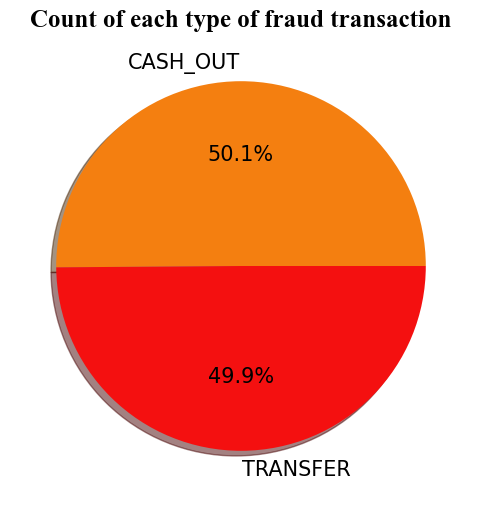

In [37]:
counts = df_original[(df_original['isFraud']==1)].groupby('type').count()['amount']
plt.figure(figsize = (6,6))
plt.pie(counts, labels = counts.index, autopct = "%1.1f%%", colors=['#F47F10', '#F41010', '#F47810', '#F4C010','#F4D510'], shadow = True,explode = (0, 0),textprops={'fontsize': 15})
plt.title('Count of each type of fraud transaction', fontweight = 'bold', fontsize = 18, fontfamily = 'times new roman')
plt.show()

### How many hours usually take fraudulent transactions

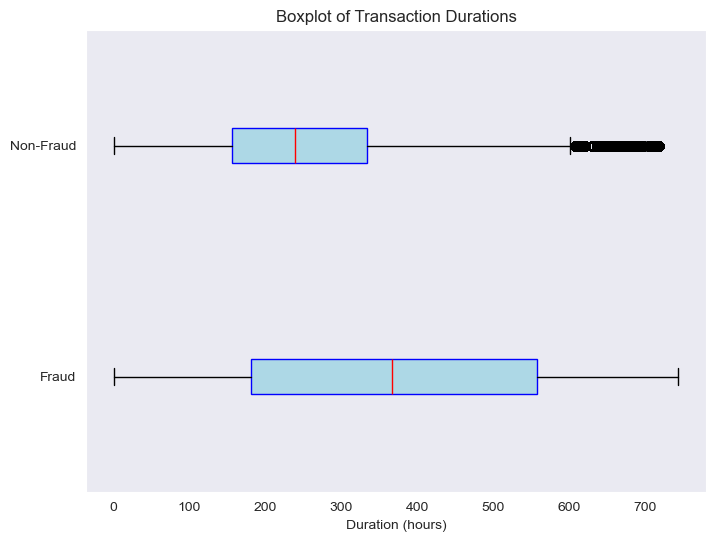

In [260]:

fraud_durations = df_original[df_original['isFraud'] == 1]['step']
non_fraud_durations = df_original[df_original['isFraud'] == 0]['step']

all_durations = [fraud_durations, non_fraud_durations]

plt.figure(figsize=(8, 6))
plt.boxplot(
    all_durations,
    vert=False,
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
    medianprops=dict(color='red'),
    tick_labels=['Fraud', 'Non-Fraud']
)
plt.title('Boxplot of Transaction Durations')
plt.xlabel('Duration (hours)')
plt.show()

### Average of Amount of fraudulent transactions vs non-fraudulent ones.

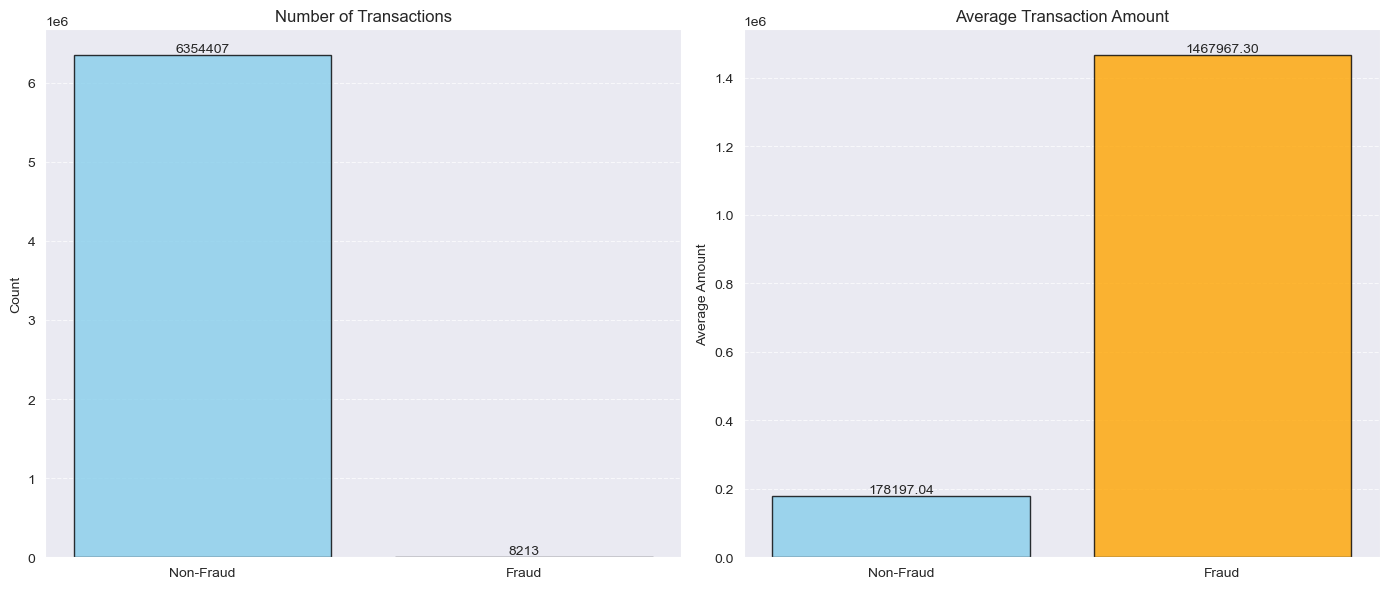

In [268]:
fraud_amount = df_original[df_original['isFraud'] == 1]['amount'].mean()
non_fraud_amount = df_original[df_original['isFraud'] == 0]['amount'].mean()

all_amount = [fraud_amount, non_fraud_amount]


counts = df_original['isFraud'].value_counts()

avg_amounts = df_original.groupby('isFraud')['amount'].mean()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

bars1 = axes[0].bar(
    ['Non-Fraud', 'Fraud'], 
    counts, 
    color=['skyblue', 'orange'], 
    alpha=0.8, 
    edgecolor='black'
)
axes[0].set_title('Number of Transactions')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars1:
    yval = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

bars2 = axes[1].bar(
    ['Non-Fraud', 'Fraud'], 
    avg_amounts, 
    color=['skyblue', 'orange'], 
    alpha=0.8, 
    edgecolor='black'
)
axes[1].set_title('Average Transaction Amount')
axes[1].set_ylabel('Average Amount')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars2:
    yval = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Dimensionality Reduction - Test Hypothesis

### Anderson-Darling Test for Normality

In [120]:
def normality_test_print(field, name):
    
    result = anderson(field, dist='norm')
    if result.statistic > result.critical_values[2]:  # Using the 5% significance level
        print("\n %s: The null hypothesis (data follows a normal distribution) is rejected."%name)
    else:
        print("\n %s: The null hypothesis (data doesn't follow a normal distribution) cannot be rejected."%name)

In [126]:
normality_test_print(df['step'], 'step')

normality_test_print(df['type'], 'type')

normality_test_print(df['amount'], 'amount')

normality_test_print(df['isFraud'], 'isFraud')

normality_test_print(df['nameOrig'], 'nameOrig')

normality_test_print(df['oldbalanceOrg'], 'oldbalanceOrg')

normality_test_print(df['newbalanceOrig'], 'newbalanceOrig')

normality_test_print(df['nameDest'], 'nameDest')

normality_test_print(df['oldbalanceDest'], 'oldbalanceDest')

normality_test_print(df['newbalanceDest'], 'newbalanceDest')



 step: The null hypothesis (data follows a normal distribution) is rejected.

 type: The null hypothesis (data follows a normal distribution) is rejected.

 amount: The null hypothesis (data follows a normal distribution) is rejected.

 isFraud: The null hypothesis (data follows a normal distribution) is rejected.

 nameOrig: The null hypothesis (data follows a normal distribution) is rejected.

 oldbalanceOrg: The null hypothesis (data follows a normal distribution) is rejected.

 newbalanceOrig: The null hypothesis (data follows a normal distribution) is rejected.

 nameDest: The null hypothesis (data follows a normal distribution) is rejected.

 oldbalanceDest: The null hypothesis (data follows a normal distribution) is rejected.

 newbalanceDest: The null hypothesis (data follows a normal distribution) is rejected.


### Pearson Correlation Matrix

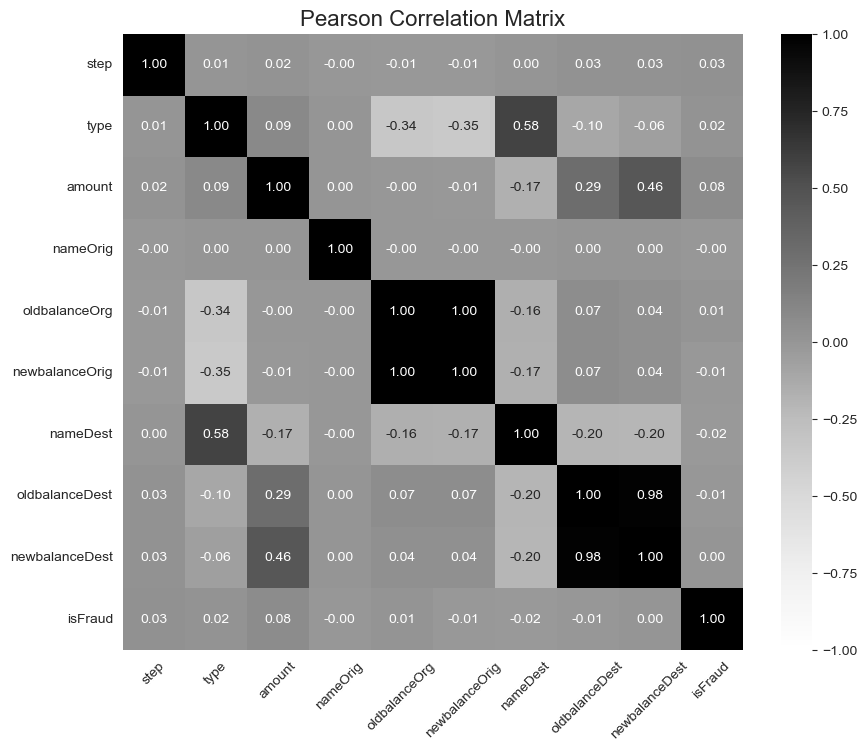

In [129]:
correlation = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation,vmin = -1, vmax = 1,cmap = "Greys",annot = True, fmt = '.2f')
plt.title('Pearson Correlation Matrix', fontsize=16)
plt.xticks(rotation = 45)
plt.show()

### Logistic Regression Test Hypothesis

In [160]:
def calculate_logisticregression_print(independent_variable, dependent_variable):
  independent_variable = sm.add_constant(independent_variable) 

  logit_model = sm.Logit(dependent_variable, independent_variable)
  result = logit_model.fit()

  # Display the summary, which includes p-values for hypothesis testing
  print(result.pvalues)

In [162]:
#Does step have any relationship with fraudulent transaction?
# Significant pValue. Not eliminate it.
calculate_logisticregression_print(df_original['step'] , df_original['isFraud'])

Optimization terminated successfully.
         Current function value: 0.009430
         Iterations 11
const    0.0
step     0.0
dtype: float64


In [164]:
#Does amount have any relationship with fraudulent transaction?
# Significant pValue. Not eliminate it.
calculate_logisticregression_print(df_original['amount'] , df_original['isFraud'])

Optimization terminated successfully.
         Current function value: 0.009658
         Iterations 11
const     0.0
amount    0.0
dtype: float64


In [166]:
#Does nameOrig have any relationship with fraudulent transaction?
# Not significant pValue. Eliminate it.
calculate_logisticregression_print(df['nameOrig'] , df['isFraud'])

Optimization terminated successfully.
         Current function value: 0.009877
         Iterations 11
const       0.000000
nameOrig    0.242073
dtype: float64


In [168]:
#Does oldbalanceOrg have any relationship with fraudulent transaction?
# Significant pValue. Eliminate it though, since documentations recomends it.
calculate_logisticregression_print(df_original['oldbalanceOrg'] , df_original['isFraud'])


Optimization terminated successfully.
         Current function value: 0.009841
         Iterations 11
const             0.000000e+00
oldbalanceOrg    1.008079e-136
dtype: float64


In [169]:
#Does newbalanceOrig have any relationship with fraudulent transaction?
# Significant pValue. Eliminate it though, since documentations recomends it.
calculate_logisticregression_print(df_original['newbalanceOrig'] , df_original['isFraud'])

Optimization terminated successfully.
         Current function value: 0.009812
         Iterations 13
const             0.000000e+00
newbalanceOrig    4.952099e-79
dtype: float64


In [170]:
#Does oldbalanceDest have any relationship with fraudulent transaction?
# Significant pValue. Eliminate it though, since documentations recomends it.
calculate_logisticregression_print(df_original['oldbalanceDest'] , df_original['isFraud'])

Optimization terminated successfully.
         Current function value: 0.009834
         Iterations 12
const             0.000000e+00
oldbalanceDest    5.620780e-76
dtype: float64


In [171]:
#Does newbalanceDest have any relationship with fraudulent transaction?
# Not significant pValue. Eliminate it.
calculate_logisticregression_print(df_original['newbalanceDest'] , df_original['isFraud'])

Optimization terminated successfully.
         Current function value: 0.009877
         Iterations 11
const             0.000000
newbalanceDest    0.174913
dtype: float64


### Logistic Regression Test Hypothesis - interpretation

The following variables are keept into dataset to train model due to their significant relation with dependent variable (isFraud):
- step
- amount

#### Expert Knowledge

The following variables are removed due to either, they low relationship with dependent variable, or are recommended to be removed in referenced paper(*):
- nameOrig
- oldbalanceOrg
- newbalanceOrig
- oldbalanceDest
- newbalanceDest

(*) E. A. Lopez-Rojas, A. Elmir, and S. Axelsson. "PaySim: A financial mobile money simulator for fraud detection". In: The 28th European Modeling and Simulation Symposium-EMSS, Larnaca, Cyprus. 2016




### Chi-Square Test Hypothesis

In [186]:
def calculate_chisquare_print(independent_variable, dependent_variable):
  ct=pd.crosstab(independent_variable, dependent_variable)
  cs= scipy.stats.chi2_contingency(ct) 
  print ('pValue: %f'%cs[1])

In [188]:
#Does type have any relationship with fraudulent transaction?
# Significant pValue. Not eliminate it.
calculate_chisquare_print(df_original['type'] , df_original['isFraud'])

pValue: 0.000000


In [192]:
#Does nameDest have any relationship with fraudulent transaction?
# Significant pValue. Not eliminate it.
calculate_chisquare_print(df['nameDest'] , df_original['isFraud'])

pValue: 0.000000


### Chi-Square Test Hypothesis - interpretation

The following variable is keept into dataset to train model due to its significant relation with dependent variable (isFraud):
- type

#### Expert Knowledge

The following variable is removed due to either, its low relationship with dependent variable, or is recommended to be removed in referenced paper(*):
- nameDest
  
(*) E. A. Lopez-Rojas, A. Elmir, and S. Axelsson. "PaySim: A financial mobile money simulator for fraud detection". In: The 28th European Modeling and Simulation Symposium-EMSS, Larnaca, Cyprus. 2016

## Data Preparation

### Keep Significant Variables

In [204]:
df.drop(['nameOrig'], inplace=True, axis=1)
df.drop(['oldbalanceOrg'], inplace=True, axis=1)
df.drop(['newbalanceOrig'], inplace=True, axis=1)
df.drop(['oldbalanceDest'], inplace=True, axis=1)
df.drop(['newbalanceDest'], inplace=True, axis=1)
df.drop(['nameDest'], inplace=True, axis=1)
isFraud_field_no_normalise = df['isFraud']
df = df.drop('isFraud', axis = 1)

### Normalization

In [206]:
df = (df - df.min()) / (df.max() - df.min())

### Split dataset into train and test

In [209]:
# separating feature variables and class variables
X = df
y = isFraud_field_no_normalise

# splitting the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

## Create Predictive Models

### Logistic Regression

In [214]:
logreg = LogisticRegression()

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found by GridSearchCV
print("Best hyperparameters:", grid_search.best_params_)
#Best hyperparameters: {'C': 0.01, 'solver': 'liblinear'}

# Print the best score achieved by GridSearchCV
print("Best score:", grid_search.best_score_)
#Best score: 0.9987026907605161

# Make predictions on the test data using the best model
y_pred = grid_search.best_estimator_.predict(X_test)

# recall of the logistic regression
recall_lr = recall_score(y_test, y_pred)

# classification report
classification_lr = classification_report(y_test, y_pred)

print(f"Recall of logistic regression {recall_lr}")
print(f"Classification Report of logistic regression\n {classification_lr}")

Best hyperparameters: {'C': 0.01, 'solver': 'liblinear'}
Best score: 0.9987026907605161


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Recall of logistic regression 0.0
Classification Report of logistic regression
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.00      0.00      0.00      2435

    accuracy                           1.00   1908786
   macro avg       0.50      0.50      0.50   1908786
weighted avg       1.00      1.00      1.00   1908786



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Support Vector Machine

In [ ]:
# Adjust class weights: make anomalies more important (heavier weight for class 1)
class_weights = {0: 1, 1: 10}  # 0 for normal, 1 for anomalies

# Fit the SVM classifier with class weights
clf = svm.SVC(kernel="rbf", gamma="scale", C=1, class_weight=class_weights)
clf.fit(X_train, y_train)

# Predict the labels (0 for normal, 1 for anomalous)
y_pred = clf.predict(X_test)

joblib.dump(clf, 'svm_model.pkl')

#Mesure model
recall_lr = recall_score(y_test, y_pred)
# classification report
classification_lr = classification_report(y_test, y_pred)
print(f"Recall of SVM {recall_lr}")
print(f"Classification Report of SVM\n {classification_lr}")

![alt text](svm_output.jpeg "Title")

### Treshold Amount and Duration of Transaction

Steps: 500 Hours

Amount: 18000000

![alt text](treshold_amount.png "Title")

### Furder Discussions

Due to hardware limitations, grid search mechanism applied to SVM will be considered in next studies training it with CUDA Nvidia:

In [ ]:
#Grid Search With CUDA
from cuml.svm import SVC as cumlSVC

param_grid = {
    'C': [0.1, 10, 100],
    'gamma': ['scale', 1, 10],
    'kernel': ['poly', 'rbf'],
    'class_weight': [{0: 1, 1: 10}, {0: 1, 1: 100}]  # Automatically handle class imbalance
}

# Perform manual grid search
best_params = None
best_model = None
best_score = -np.inf

for params in ParameterGrid(param_grid):
    print(f"Training with parameters: {params}")
    model = cumlSVC(
        C=params['C'], gamma=params['gamma'], kernel=params['kernel'], class_weight=params['class_weight']
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = classification_report(y_test, y_pred, output_dict=True)['1']['f1-score']

    if score > best_score:
        best_score = score
        best_model = model
        best_params = params
        print("\nBest Pre_Score:", best_score)
        print("\nBest Pre_Params:", best_params)
        joblib.dump(best_model, 'svm_pre_best_model.pkl')

# Display the best parameters and score
print("\nBest Parameters:", best_params)
print(f"Best Weighted F1-Score: {best_score:.4f}")

# Evaluate the best model
y_pred = best_model.predict(X_test)
joblib.dump(best_model, 'svm_best_model.pkl')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))